In [20]:
import feyn

In [51]:
# Connect to your QLattice
from feyn import QLattice

qlattice = QLattice(url="", api_token="")

In [2]:
from dsx.ds_utils import *
import re, dtale, pandas_profiling, pandas_summary, qgrid

Package loaded in Notebook Mode
Successfully imported ds_utils as Package


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
sns.set_context(context={'figure.figsize': (16,9)})
qgrid.set_grid_option('forceFitColumns', False)

# Loading Data

In [4]:
df = pd.read_csv('processed_data/hdb_resale_geoinfo_processed.csv')

# Feature Engineering

In [5]:
df['block_age_at_resale'] = df.resale_year - df.year_completed

In [6]:
df['floor_proportion'] = df['unit_storey_cap'] / df['max_floor_lvl']
df['floor_proportion'] = df['floor_proportion'].map(lambda x: x if x <= 1 else 1)

In [7]:
df['price_per_sqm'] = df.resale_price / df.floor_area_sqft

# Features Encoding

In [23]:
semantic_types = {}

for col in df.columns:
    if df[col].dtype == 'object':
        semantic_types[col] = 'c'
        
target = 'price_per_sqm' #Also we serve the QLattice the target

In [25]:
semantic_types

{'town': 'c', 'flat_type': 'c', 'flat_model': 'c', 'station_type': 'c'}

# Modeling

In [9]:
from sklearn import preprocessing, model_selection, metrics

## Features Selection

In [15]:
df.drop(['latitude', 'longitude', 'year_completed', 'block', 'street_name', 'postal', 'storey_range', 'floor_area_sqm', 'lease_commence_date', 'station_name'], axis=1, inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164825 entries, 0 to 164824
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   resale_year                     164825 non-null  int64  
 1   resale_month                    164825 non-null  int64  
 2   town                            164825 non-null  object 
 3   flat_type                       164825 non-null  object 
 4   flat_model                      164825 non-null  object 
 5   max_floor_lvl                   164825 non-null  int64  
 6   station_type                    164825 non-null  object 
 7   station_nearest_distance_meter  164825 non-null  int64  
 8   hawker_nearest_distance_meter   164825 non-null  int64  
 9   hawker_count_within_500m        164825 non-null  int64  
 10  hawker_count_within_1km         164825 non-null  int64  
 11  hawker_count_within_2km         164825 non-null  int64  
 12  mall_nearest_dis

## Modeling

In [17]:
train, test = model_selection.train_test_split(df, random_state=2048)

In [52]:
qgraph = qlattice.get_regressor(train.columns, output=target, max_depth=7, stypes = semantic_types)

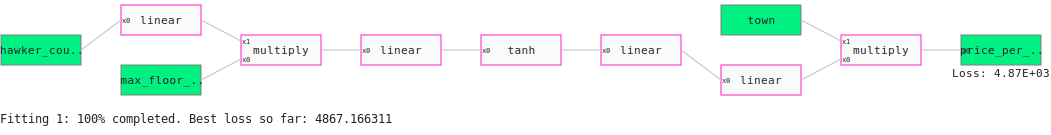

QGraph (depth<=7) <head: 1872>

In [53]:
qgraph.fit(train, loss_function=feyn.losses.squared_error)

In [44]:
best = qgraph.sort(train, loss_function=feyn.losses.absolute_error)[0]

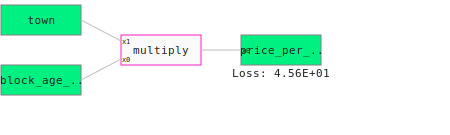

In [37]:
best

In [47]:
best5 = qgraph.best(5)

In [48]:
for best in best5:
    prediction = best.predict(test)
    print(np.sqrt(metrics.mean_squared_error(test[target], prediction)))

58.20265675007578
59.01603520192357
66.33448332740943


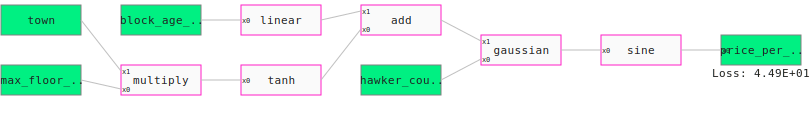

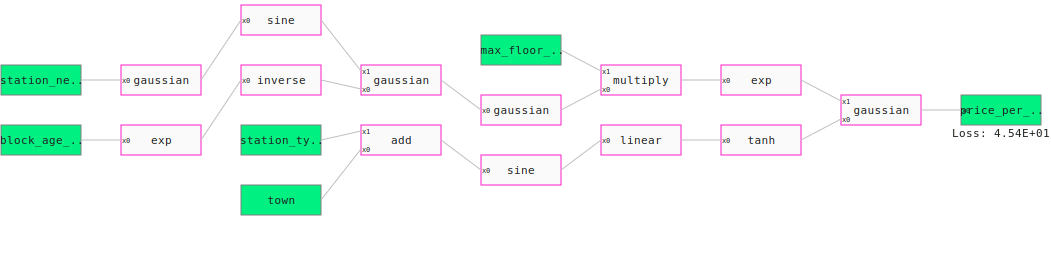

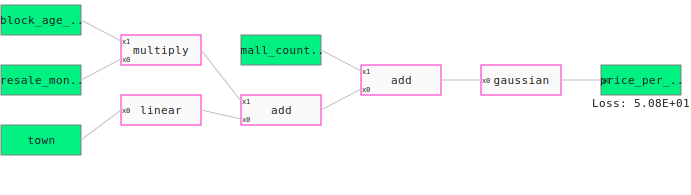

In [50]:
for best in best5:
    best

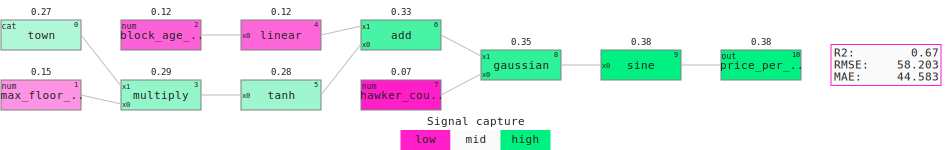

In [56]:
best5[0].plot_summary(test)

In [60]:
from feyn.__future__.contrib.inspection import plot_interaction, plot_categories, get_activations_df

In [58]:
graph = best5[0]

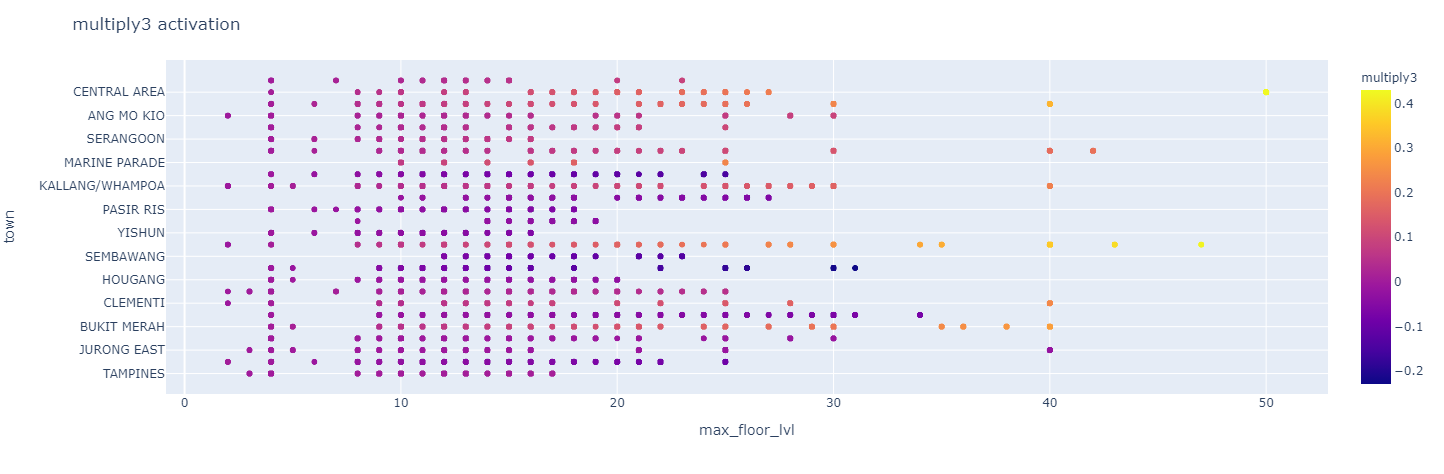

In [76]:
fig = plot_interaction(graph, graph[3], test)
fig.show()